### Importing dependencies

In [ ]:
import os
from google.colab import drive

from tqdm import notebook as tqdm
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Loading and Pre Processing Data

Resizing the images (so they each have the same amount of pixels, not to overfit to larger images) and converting them to Tensor, so they can be used in the model.

Import the data from Google Drive as we assume that this is running on Google Colab.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
means = [0.3769291937351227, 0.4391755163669586, 0.3163606822490692]
stds = [0.19574914872646332, 0.1959507316350937, 0.1705385148525238]
transform_train = Compose([RandomHorizontalFlip(), RandomVerticalFlip(), Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_val = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_test = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])


train_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/train",transform=transform_train)
val_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/val",transform=transform_val)
test_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/test",transform=transform_test)
diffBg_dataset = ImageFolder(root="/content/drive/MyDrive/diffBg",transform=transform_test)

### Use a GPU if available

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

## Defining the EfficientNet Model Architecture

> Add blockquote



In [ ]:

import torch
from torch import nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=4):
        super(SEBlock, self).__init__()
        reduced_dim = in_channels // reduction_ratio
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.ReLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio):
        super(MBConvBlock, self).__init__()
        self.use_res_connect = stride == 1 and in_channels == out_channels
        hidden_dim = in_channels * expand_ratio
        self.expansion = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ) if expand_ratio != 1 else nn.Identity()

        self.depthwise = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, kernel_size//2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        )

        self.se = SEBlock(hidden_dim)

        self.pointwise = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion(x)
        out = self.depthwise(out)
        out = self.se(out)
        out = self.pointwise(out)
        if self.use_res_connect:
            out = out + x
        return out

class EfficientNet(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNet, self).__init__()
        # Adjust the initial number of channels and the number of output classes
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        # Define a series of MBConv blocks
        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, 3, 1, 1),
            MBConvBlock(16, 24, 3, 2, 6),  # Downsample
            MBConvBlock(24, 40, 5, 2, 6),  # Downsample
            # More blocks can be added here with appropriate parameters
        )

        self.head = nn.Sequential(
            nn.Conv2d(40, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Perform a sanity check for the correctness of the model

In [ ]:
net = EfficientNet(num_classes=4)
net = net.to(device)
data = torch.randn(5,3,64,64)
data = data.to(device)
out = net.forward(data)
assert(out.detach().cpu().numpy().shape == (5,4))
print("Forward pass successful, shape matches")

for layer in net.children():
  print(layer)
  print(sum(p.numel() for p in layer.parameters()))

Forward pass successful, shape matches
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
928
Sequential(
  (0): MBConvBlock(
    (expansion): Identity()
    (depthwise): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (se): SEBlock(
      (se): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU()
        (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
    )
    (pointwise): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affi

### Move data and the model to the GPU

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=16)
diffBg_dl = DataLoader(diffBg_dataset, batch_size=16)

!nvidia-smi

Sun May 12 06:07:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              26W /  70W |    171MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining a Loss Function and Optimizer

In [ ]:
# hyperparameters
INITIAL_LR = 0.1 # initial learning rate
MOMENTUM = 0.9 # momentum for optimizer

REG = 1e-3 # L2 regularization strength

criterion = nn.CrossEntropyLoss() # loss function

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay = REG)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY_EPOCHS = 10
DECAY = 1

## Train the model

In [ ]:
print("Training:")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(0, EPOCHS):
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    net.train() # switch to train mode

    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0

    train_loss = 0

    # 1 epoch training
    for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(train_dl), "training..."):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = net.forward(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # count the number of correctly predicted samples in the current batch

        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        correct_examples += correct
        total_examples += len(targets)
        train_loss += loss

    avg_loss = train_loss / len(train_dl)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    history['train_loss'].append(avg_loss)
    history['train_acc'].append(avg_acc)

    net.eval()

    total_examples = 0
    correct_examples = 0

    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(val_dl), "validating..."):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            correct_examples += correct
            total_examples += len(targets)
            val_loss += loss

    avg_loss = val_loss / len(val_dl)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    history['val_loss'].append(avg_loss)
    history['val_acc'].append(avg_acc)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'efficientnetSegmented.pth'))

    print('')

print("="*50)
print(f"Optimization finished: best validation accuracy is {best_val_acc:.4f}")

Training:
Epoch 0:


training...: 0it [00:00, ?it/s]

Training loss: 1.4038, Training accuracy: 0.5846


validating...: 0it [00:00, ?it/s]

Validation loss: 2.5713, Validation accuracy: 0.5395
Saving ...

Epoch 1:


training...: 0it [00:00, ?it/s]

Training loss: 0.7719, Training accuracy: 0.7461


validating...: 0it [00:00, ?it/s]

Validation loss: 1.2515, Validation accuracy: 0.5969
Saving ...

Epoch 2:


training...: 0it [00:00, ?it/s]

Training loss: 0.4718, Training accuracy: 0.8140


validating...: 0it [00:00, ?it/s]

Validation loss: 0.7398, Validation accuracy: 0.7189
Saving ...

Epoch 3:


training...: 0it [00:00, ?it/s]

Training loss: 0.4282, Training accuracy: 0.8297


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5078, Validation accuracy: 0.8289
Saving ...

Epoch 4:


training...: 0it [00:00, ?it/s]

Training loss: 0.3720, Training accuracy: 0.8549


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4667, Validation accuracy: 0.7990

Epoch 5:


training...: 0it [00:00, ?it/s]

Training loss: 0.3397, Training accuracy: 0.8696


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3475, Validation accuracy: 0.8672
Saving ...

Epoch 6:


training...: 0it [00:00, ?it/s]

Training loss: 0.3214, Training accuracy: 0.8768


validating...: 0it [00:00, ?it/s]

Validation loss: 0.7812, Validation accuracy: 0.7225

Epoch 7:


training...: 0it [00:00, ?it/s]

Training loss: 0.3308, Training accuracy: 0.8737


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5643, Validation accuracy: 0.7691

Epoch 8:


training...: 0it [00:00, ?it/s]

Training loss: 0.3002, Training accuracy: 0.8857


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3719, Validation accuracy: 0.8553

Epoch 9:


training...: 0it [00:00, ?it/s]

Training loss: 0.2761, Training accuracy: 0.9003


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3534, Validation accuracy: 0.8672

Current learning rate has decayed to 0.100000
Epoch 10:


training...: 0it [00:00, ?it/s]

Training loss: 0.2712, Training accuracy: 0.8952


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3888, Validation accuracy: 0.8600

Epoch 11:


training...: 0it [00:00, ?it/s]

Training loss: 0.2672, Training accuracy: 0.8993


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3750, Validation accuracy: 0.8648

Epoch 12:


training...: 0it [00:00, ?it/s]

Training loss: 0.2880, Training accuracy: 0.8894


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3718, Validation accuracy: 0.8672

Epoch 13:


training...: 0it [00:00, ?it/s]

Training loss: 0.2415, Training accuracy: 0.9143


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3146, Validation accuracy: 0.8744
Saving ...

Epoch 14:


training...: 0it [00:00, ?it/s]

Training loss: 0.2477, Training accuracy: 0.9061


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3092, Validation accuracy: 0.8971
Saving ...

Epoch 15:


training...: 0it [00:00, ?it/s]

Training loss: 0.2434, Training accuracy: 0.9072


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5445, Validation accuracy: 0.8098

Epoch 16:


training...: 0it [00:00, ?it/s]

Training loss: 0.2401, Training accuracy: 0.9133


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3326, Validation accuracy: 0.8708

Epoch 17:


training...: 0it [00:00, ?it/s]

Training loss: 0.2572, Training accuracy: 0.9075


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5814, Validation accuracy: 0.7835

Epoch 18:


training...: 0it [00:00, ?it/s]

Training loss: 0.2325, Training accuracy: 0.9126


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3980, Validation accuracy: 0.8361

Epoch 19:


training...: 0it [00:00, ?it/s]

Training loss: 0.2290, Training accuracy: 0.9157


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3772, Validation accuracy: 0.8529

Current learning rate has decayed to 0.100000
Epoch 20:


training...: 0it [00:00, ?it/s]

Training loss: 0.2398, Training accuracy: 0.9130


validating...: 0it [00:00, ?it/s]

Validation loss: 0.6319, Validation accuracy: 0.7548

Epoch 21:


training...: 0it [00:00, ?it/s]

Training loss: 0.2275, Training accuracy: 0.9164


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3176, Validation accuracy: 0.8828

Epoch 22:


training...: 0it [00:00, ?it/s]

Training loss: 0.2181, Training accuracy: 0.9195


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3804, Validation accuracy: 0.8792

Epoch 23:


training...: 0it [00:00, ?it/s]

Training loss: 0.2076, Training accuracy: 0.9253


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4294, Validation accuracy: 0.8600

Epoch 24:


training...: 0it [00:00, ?it/s]

Training loss: 0.2255, Training accuracy: 0.9133


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3388, Validation accuracy: 0.8804

Epoch 25:


training...: 0it [00:00, ?it/s]

Training loss: 0.2073, Training accuracy: 0.9208


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3264, Validation accuracy: 0.8768

Epoch 26:


training...: 0it [00:00, ?it/s]

Training loss: 0.1918, Training accuracy: 0.9297


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2771, Validation accuracy: 0.8900

Epoch 27:


training...: 0it [00:00, ?it/s]

Training loss: 0.2104, Training accuracy: 0.9195


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3451, Validation accuracy: 0.8648

Epoch 28:


training...: 0it [00:00, ?it/s]

Training loss: 0.2053, Training accuracy: 0.9249


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3721, Validation accuracy: 0.8648

Epoch 29:


training...: 0it [00:00, ?it/s]

Training loss: 0.2082, Training accuracy: 0.9208


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4453, Validation accuracy: 0.8266

Optimization finished: best validation accuracy is 0.8971


### Show the plots of the training and validation losses

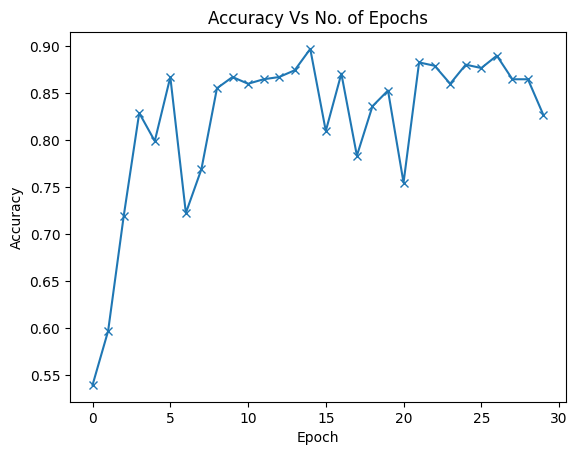

In [ ]:
def plot_accuracies(history):
  accuracies = [x.cpu().item() for x in history['val_acc']]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy Vs No. of Epochs")

plot_accuracies(history)

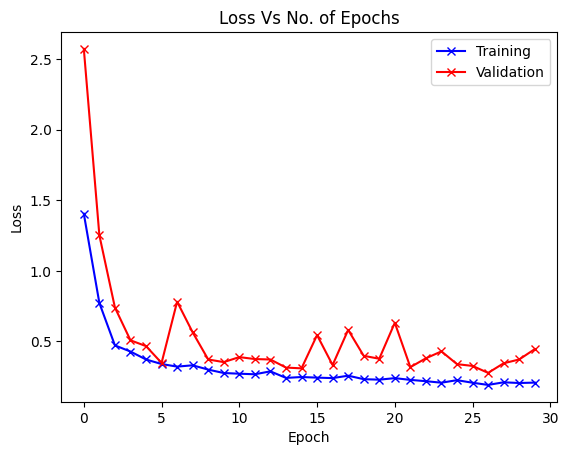

In [ ]:
def plot_losses(history):
  train_losses = [x.cpu().item() for x in history['train_loss']]
  val_losses = [x.cpu().item() for x in history['val_loss']]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training','Validation'])
  plt.title("Loss Vs No. of Epochs")
plot_losses(history)

### Evaluate the model with the test set

evaluating...:   0%|          | 0/27 [00:00<?, ?it/s]

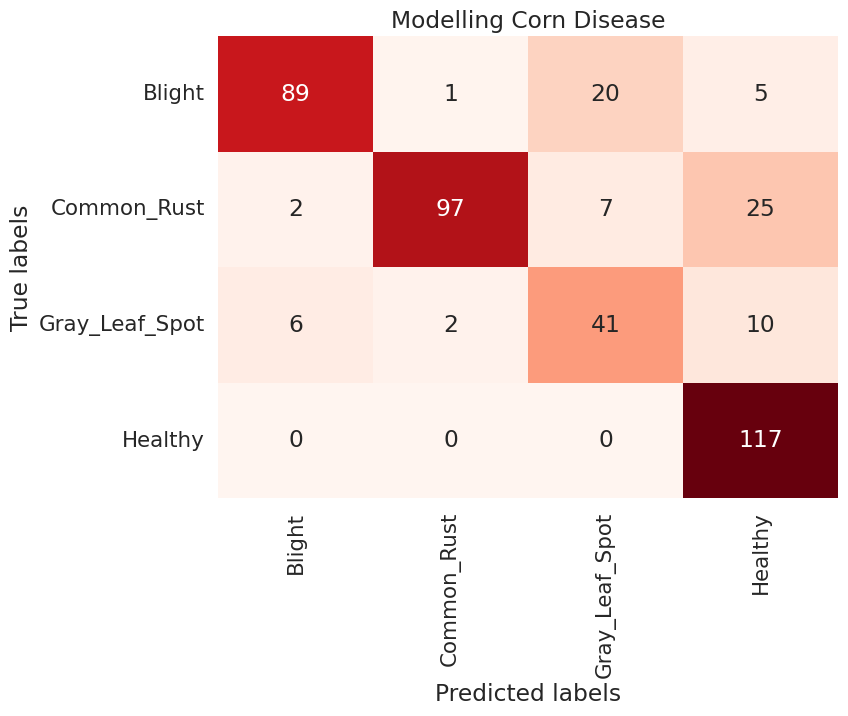

In [ ]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(test_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Modelling Corn Disease')
plt.show()

## Additional testing on images with different backgrounds

evaluating...:   0%|          | 0/17 [00:00<?, ?it/s]

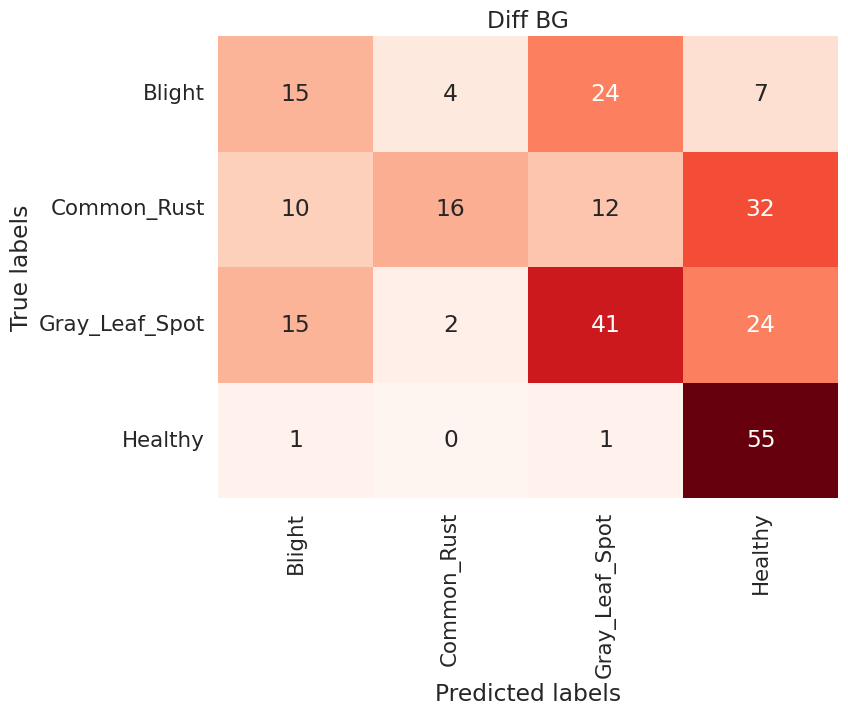

In [ ]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(diffBg_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Diff BG')
plt.show()